# Total Variation Image Deblurring (and Denoising)
#### **Theory and algorithm from:** Fischer, B., & Modersitzki, J. (2004). A unified approach to fast image registration and a new curvature based registration technique. *Linear Algebra and its applications, 380*, 107-124.

#### **Notebook by:** Daniel Antonio Brito Pacheco, BSc



Our goal is to minimize the following integral:
$$\int_{\Omega} |\nabla u| \,dx \, dy,$$
where $u$ is a blurry image, and $\Omega$ is the image domain. The minimization is subject to the following constraint:
$$\int_{\Omega}Ku \,dx \,dy = \int_{\Omega}u_0 \,dx \,dy,$$
where $K$ is a Gaussian Filter Kernel.

The above optimization problem can be transformed into an unconstrained minimization problem using the Lagrange formulation as:
$$
\min_u \bigg\{ \int_\Omega |\nabla u| \,dx \,dy + \frac{\lambda}{2} || Ku -u_0 ||_{L^2}^2 \,dx \,dy \bigg\}
$$
The Euler-Lagrange equation for the above functional yields the following gradient descent solution:
$$
\frac{\partial u}{\partial t} = \nabla \cdot \bigg( \frac{\nabla u}{|\nabla u|} \bigg) - \lambda \Big( K*\big( Ku - u_0 \big) \Big). \tag{1}
$$
Where $*$ is the convolution operator. In this notebook I present an implementation of this gradient descent algorithm.

In [ ]:
# If on Google Drive, run this cell to mount your drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# First, import all necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rndm
from PIL import Image
from scipy import signal

In [ ]:
# This function defines the gaussian convolution operation of an image using the submodule signal from scipy
# effectively, this function is used to also make the blurry image

def convolve(u, filter_size=20):
    t = np.linspace(-10, 10, filter_size)
    bump = np.exp(-0.1*t**2)
    bump /= np.trapz(bump)    # normalize the integral to 1
    # make a 2-D kernel out of it
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    # mode='same' is there to enforce the same output shape as input arrays
    img3 = signal.fftconvolve(u, kernel, mode='same')
    return(img3)

In [ ]:
# This function is simply used to add noise to an image

def add_noise(u, mu, sigma):
    n = rndm.normal(loc=mu, scale=sigma, size = (u.shape))
    noisy = u + n
    return(noisy)

In [ ]:
# This function calculates the first term in the right-hand-side of equation (1)

def divergence(u, delta=0.00001):    # delta is a small term used to avoid division by 0
    grad_u = np.gradient(u)
    grad_u = grad_u/ (np.sqrt(grad_u[0]**2 + grad_u[1]**2 + delta) ) # divide by the norm of the gradient
    
    ux = grad_u[0]
    uy = grad_u[1]                  # ux and uy are the first partial derivatives
    uxx = np.gradient(ux)[0]
    uyy = np.gradient(uy)[1]        # uxx and uyy are the second partial derivatives
    
    div = uxx + uyy
    return(div)

In [ ]:
# This function performs the gradient descent

def grad_descent(u0, N_iter, lam, alpha=0.001):
    u_old = u0
    norm_history = []
    for i in range(N_iter):
        div = divergence(u_old)
        
        Ku = convolve(u_old)        # Convolve u with the kernel K
        adj = convolve(Ku - u0)     # This is K*(Ku - u0)
        grad = -div + lam*(adj)    # Calculate du/dt
        
        # Below we print the Gradient Norm every 200 iterations
        if i % 200 == 0:
            norm = np.linalg.norm(grad)
            print('Iteration = ', i, ' Gradient Norm = ', np.linalg.norm(grad))
            norm_history.append(norm)
        
        u_new = u_old - alpha*grad
        u_old = u_new
    return(u_new, norm_history)

In [ ]:
# Read the image and turn it into a numpy array with values between 0 and 1
pic = Image.open("drive/MyDrive/MCC/2do Semestre (Ene - May 2023)/Variational Models/Deblurring and Denoising/cameraman.png")
gs = pic.convert('L')
img = np.array(gs)
img = img/255

In [ ]:
# Set parameters and hyperparameters
var = 0.01
sig = np.sqrt(var)
mean = 0
N_iter = 2001
lamb = 200

# Add noise and blur to the image
img_blurred = add_noise(img, mean, sig)
img_blurred = convolve(img_blurred)

# Deblur using the gradient descent function
img_deblurred, norm_history = grad_descent(img_blurred, N_iter, lamb)

Iteration =  0  Gradient Norm =  1668.9075084938072
Iteration =  200  Gradient Norm =  29.04943777663503
Iteration =  400  Gradient Norm =  12.09928017925008
Iteration =  600  Gradient Norm =  7.179504912374435
Iteration =  800  Gradient Norm =  5.038081717864595
Iteration =  1000  Gradient Norm =  3.9450308985054576
Iteration =  1200  Gradient Norm =  3.4544203950472006
Iteration =  1400  Gradient Norm =  2.622631796021214
Iteration =  1600  Gradient Norm =  2.5487693727315257
Iteration =  1800  Gradient Norm =  2.312468972082718
Iteration =  2000  Gradient Norm =  2.3344057243756997


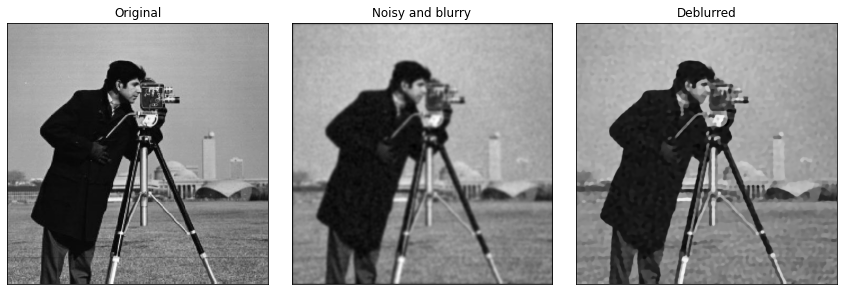

In [ ]:
# Graph all the images
fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(img_blurred, cmap='gray')
axs[1].set_title('Noisy and blurry')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(img_deblurred, cmap='gray')
axs[2].set_title('Deblurred')
axs[2].set_xticks([])
axs[2].set_yticks([])

fig.tight_layout()

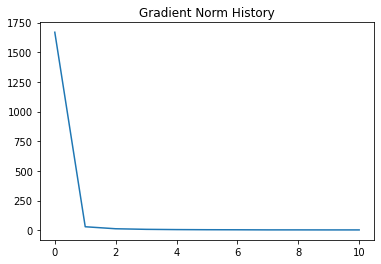

In [ ]:
# Graph the norm history

X = np.linspace(0, N_iter-1, int(np.round(N_iter/200)+1))
fig, ax = plt.subplots(1,1)
ax.set_title('Gradient Norm History')

ax.plot(norm_history)